<a href="https://colab.research.google.com/github/sokrypton/ColabBio/blob/main/notebooks/miniaturize_using_esm3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**miniaturize protein using ESM3**
WARNING: this is intended for illustrative purposes, might not give useful results.

Notes:
- max length: 1200 (on free colab T4 GPU)

In [ ]:
%set_env TOKENIZERS_PARALLELISM=false
#@markdown ##huggingface token
#@markdown In order to download the weights, esm requires users to accept the non-commercial license.
#@markdown
#@markdown - Go here to create accpet license: https://huggingface.co/EvolutionaryScale/esm3
#@markdown
#@markdown - Go here to get token:
#@markdown https://huggingface.co/settings/tokens
token = "" # @param {type:"string"}
from huggingface_hub import login
login(token=token, add_to_git_credential=True)

In [ ]:
%%time
#@markdown ##setup model (3m 30s)
assert "token" in dir() and token != "", "please set token"
import os
import numpy as np
import torch
import contextlib
import os
import sys

import tqdm
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from IPython.display import HTML

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

@contextlib.contextmanager
def suppress_output():
  # Save the original stdout and stderr
  original_stdout = sys.stdout
  original_stderr = sys.stderr
  try:
    # Redirect both stdout and stderr to devnull
    with open(os.devnull, 'w') as fnull:
      sys.stdout = fnull
      sys.stderr = fnull
      yield
  finally:
    # Restore original stdout and stderr
    sys.stdout = original_stdout
    sys.stderr = original_stderr

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import os
if not os.path.isfile("plot_pseudo_3D.py"):
  os.system("pip install git+https://github.com/sokrypton/esm3.git")
  os.system("wget -qnc https://raw.githubusercontent.com/sokrypton/plot_pseudo_3D/main/plot_pseudo_3D.py")

from plot_pseudo_3D import plot_pseudo_3D, make_animation, kabsch


from scipy.special import softmax, log_softmax

def sample_gumbel_numpy(shape, eps=1e-20):
  """Sample from Gumbel(0, 1)"""
  U = np.random.uniform(low=0.0, high=1.0, size=shape)
  return -np.log(-np.log(U + eps) + eps)

def weighted_inverse_entropy(ent,min_val=2,max_val=7):
  x = (max_val-ent)/(max_val-min_val)
  return np.minimum(np.maximum(x,0),1)

def get_ent(seq):
  '''compute entropy at each position'''
  ent = lambda x: -(log_softmax(x,-1) * softmax(x,-1)).sum(-1)
  protein_prompt = ESMProtein(sequence=seq)
  protein_tensor = model.encode(protein_prompt)
  with torch.no_grad():
    output = model(sequence_tokens=protein_tensor.sequence[None])
    struct_logits = output.structure_logits.to(torch.float32).cpu().numpy()[0,1:-1]
    return ent(struct_logits)

def predict_xyz(seq, num_steps=1, temperature=0.1, ca_only=True):
  structure_prediction_config = GenerationConfig(
      track="structure", # We want ESM3 to generate tokens for the structure track
      num_steps=num_steps,
      temperature=temperature,
  )
  with torch.no_grad():
    structure_prediction_prompt = ESMProtein(sequence=seq)
    with suppress_output():
      output = model.generate(structure_prediction_prompt, structure_prediction_config)
    if ca_only:
      ca = output.coordinates[:,1]
      return ca.cpu().numpy()
    else:
      return output


from esm.utils.structure.protein_chain import ProteinChain
from esm.utils.constants.esm3 import SEQUENCE_VOCAB
from esm.models.esm3 import ESM3
from esm.sdk.api import (
    ESMProtein,
    GenerationConfig,
)
model =  ESM3.from_pretrained("esm3_sm_open_v1", device=torch.device(DEVICE)).eval()

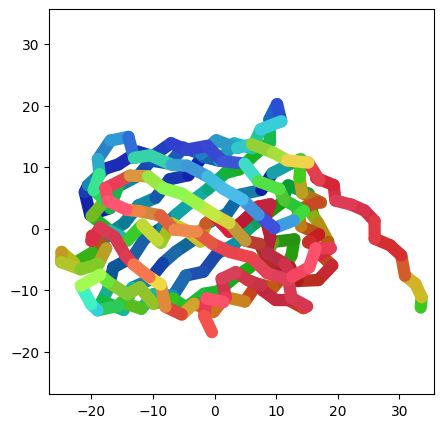

In [24]:
#@markdown ##enter sequence

sequence = "MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGSKAYVKHPADIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERAEGRHSTGGMDELYK" # @param {type:"string"}

sequence = sequence.upper()
sequence = ''.join([i for i in sequence if i.isalpha()])

OG_XYZ = predict_xyz(sequence, num_steps=1)
OG_XYZ -= OG_XYZ.mean(0,keepdims=True)
OG_XYZ @= kabsch(OG_XYZ,OG_XYZ, return_v=True)

OG_ENT = get_ent(sequence)
plot_pseudo_3D(OG_XYZ, c=weighted_inverse_entropy(OG_ENT), cmin=0, cmax=0.8)
plt.show()

# initialize optimization run
SEQ,ENT = [],[]
old_seq = list(sequence)
new_seq = list(sequence)
new_ent = OG_ENT

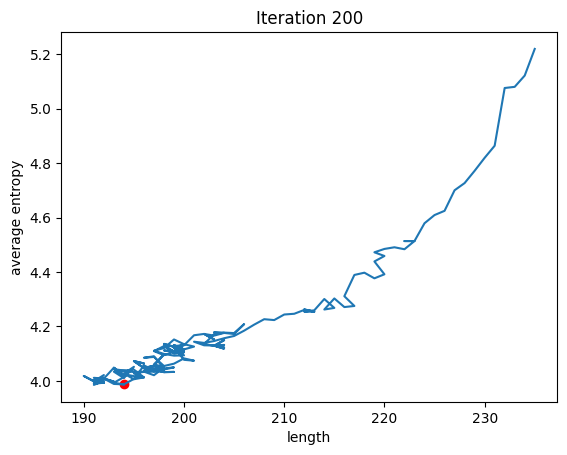

  0%|          | 0/200 [elapsed: 00:00 remaining: ?]

<Figure size 640x480 with 0 Axes>

In [25]:
#@markdown ##RUN

iterations = 200 # @param {type:"integer"}
tries = 10 # @param {type:"integer"}
allow_extensions = True # @param {type:"boolean"}

# Create an empty plot and capture the display handle
plt.figure()
plot_display = display(plt.gcf(), display_id=True)

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
with tqdm.notebook.tqdm(total=iterations, bar_format=TQDM_BAR_FORMAT) as pbar:
  for k in range(iterations):
    tries_sco = []
    tries_seq = []
    tries_ent = []

    # sample
    order = (new_ent + sample_gumbel_numpy(new_ent.shape)).argsort()[::-1]
    I = np.arange(len(new_seq))[order][:tries]
    for i in I:
      if new_ent[i] > 0:
        modes = ["a","b","c"] if allow_extensions else ["c"]
        for mode in modes:
          test_seq = new_seq.copy()
          changed = False
          if mode == "a" and i < (len(test_seq)-1) and test_seq[i+1] == "-":
            test_seq[i+1] = old_seq[i+1]
            changed = True
          if mode == "b" and i > 0 and test_seq[i-1] == "-":
            test_seq[i-1] = old_seq[i-1]
            changed = True
          if mode == "c":
            test_seq[i] = "-"
            changed = True
          if changed:
            test_seq_str = "".join([a for a in test_seq if a != "-"])
            ent = get_ent(test_seq_str)
            tries_sco.append(ent.mean())
            tries_ent.append(ent)
            tries_seq.append(test_seq)

    best_idx = np.argmin(tries_sco)
    best_sco = tries_sco[best_idx]
    best_seq = tries_seq[best_idx]
    best_ent = tries_ent[best_idx]
    best_seq_str = "".join([a for a in best_seq if a != "-"])

    ENT.append([best_ent,best_sco])
    SEQ.append([best_seq,best_seq_str])

    mask = np.array([a != "-" for a in best_seq])
    new_seq = best_seq.copy()
    new_ent = np.full(len(best_seq),-np.inf)
    new_ent[mask] = best_ent

    # Clear the previous plot and display the new one
    plt.clf()  # Clear the current figure
    plt.plot([len(x[1]) for x in SEQ], [x[1] for x in ENT])
    plt.scatter(len(SEQ[-1][1]), ENT[-1][1], c="red")
    plt.xlabel("length")
    plt.ylabel("average entropy")
    plt.title(f"Iteration {len(SEQ)}")

    # Update only the plot using the display handle
    plot_display.update(plt.gcf())

    pbar.update(1)

plt.clf()  # Clear the current figure
plt.show()

In [28]:
#@markdown ##animate (optional)
BEST_ENT = {}
BEST_SEQ = {}
for (seq, seq_str), (ent, sco) in zip(SEQ, ENT):
  L = len(seq_str)
  if L not in BEST_ENT or BEST_ENT[L][1] > sco:
    BEST_ENT[L] = [ent,sco]
    BEST_SEQ[L] = [seq,seq_str]

plot_XYZ = []
plot_ENT = []
with tqdm.notebook.tqdm(total=len(BEST_ENT), bar_format=TQDM_BAR_FORMAT) as pbar:
  for k in sorted(list(BEST_ENT.keys()))[::-1]:
    seq,seq_str = BEST_SEQ[k]
    ent,sco = BEST_ENT[k]
    L = ent.shape[0]
    x = predict_xyz(seq_str, num_steps=1)

    # Original sequence mask
    og_mask = np.array(seq) != "-"

    # Calculate weights based on inverse entropy
    weights = weighted_inverse_entropy(ent)

    # Apply weights to the coordinates
    weighted_mean_x = np.average(x, axis=0, weights=weights)
    x -= weighted_mean_x

    # Apply weights to the original coordinates
    x_og = OG_XYZ[og_mask]
    weighted_mean_x_og = np.average(x_og, axis=0, weights=weights)
    x_og -= weighted_mean_x_og

    # Perform Kabsch alignment with weighted inverse entropy
    x @= kabsch(x, x_og, weights=weights)

    plot_XYZ.append(x)
    plot_ENT.append(weighted_inverse_entropy(ent))
    pbar.update(1)

HTML(make_animation(xyz=plot_XYZ,
                    sitewise=plot_ENT,
                    sitewise_label="colored by structure-token entropy",
                    sitewise_min=0,
                    sitewise_max=0.8,
                    align_xyz=False,
                    pos_ref=OG_XYZ,
                    dpi=100).to_html5_video())

  0%|          | 0/46 [elapsed: 00:00 remaining: ?]

In [27]:
BEST_ENT = {}
BEST_SEQ = {}
for (seq, seq_str), (ent, sco) in zip(SEQ, ENT):
  L = len(seq_str)
  if L not in BEST_ENT or BEST_ENT[L][1] > sco:
    BEST_ENT[L] = [ent,sco]
    BEST_SEQ[L] = [seq,seq_str]

for k in sorted(list(BEST_ENT.keys()))[::-1]:
  seq,seq_str = BEST_SEQ[k]
  ent,sco = BEST_ENT[k]
  print("".join(seq),sco)

MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGSKAYVKHP-DIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERAEGRHSTGGMDELYK 5.219848
MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGS-AYVKHP-DIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERAEGRHSTGGMDELYK 5.1219044
MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGS-AYVKHP-DIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERA-GRHSTGGMDELYK 5.0804634
MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGS-AYVKHP-DIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERA-GRHS-GGMDELYK 5.0762224
MVSKGEEDNMAII